In [7]:
import networkx as nx
import numpy as np
import random

def genera_istanza(tipo_grafo, n_nodi, k_cluster, params_dist):
    """
    Genera un'istanza del problema Weighted K-Clustering.
    params_dist = {'w_mu': media peso, 'w_sigma': dev.std peso, 
                   'c_mu': media costo, 'c_sigma': dev.std costo}
    """
    
    # 1. Creazione Topologia
    if tipo_grafo == "grid":
        # Per grid, n_nodi deve essere un quadrato o rettangolo. Facciamo radice quadrata approx.
        lato = int(np.sqrt(n_nodi))
        G = nx.grid_2d_graph(lato, lato)
        # Rinominiamo i nodi da (0,0) a interi 0, 1, 2...
        G = nx.convert_node_labels_to_integers(G)
        nome = f"Griglia {lato}x{lato}"
        
    elif tipo_grafo == "erdos":
        # Probabilità p fissata a 0.2 per avere un grafo non troppo denso
        G = nx.erdos_renyi_graph(n=n_nodi, p=0.25, seed=42)
        # Assicuriamoci che sia connesso (opzionale ma utile)
        while not nx.is_connected(G):
             G = nx.erdos_renyi_graph(n=n_nodi, p=0.25)
        nome = f"Erdos-Renyi (n={n_nodi}, p=0.25)"

    # 2. Generazione Pesi Nodi (w_i) - Gaussiana
    weights = {}
    tot_W = 0
    for i in G.nodes():
        # Genera valore gaussiano, arrotonda, assicura che sia almeno 1
        w = int(np.random.normal(params_dist['w_mu'], params_dist['w_sigma']))
        w = max(1, w) 
        weights[i] = w
        tot_W += w
        
    # 3. Generazione Costi Archi (c_ij) - Gaussiana
    costs = {}
    for (u, v) in G.edges():
        c = np.random.normal(params_dist['c_mu'], params_dist['c_sigma'])
        c = round(max(0.1, c), 2) # Costi float, minimo 0.1
        costs[(u, v)] = c

    # 4. Calcolo Q
    # Q ≈ 3W / 2k
    Q = (3 * tot_W) / (2 * k_cluster)
    
    return {
        "nome": nome,
        "nodi": list(G.nodes()),
        "archi": list(G.edges()),
        "pesi_nodi": weights,
        "costi_archi": costs,
        "W_totale": tot_W,
        "K": k_cluster,
        "Q_limit": round(Q, 2)
    }

# Parametri della Gaussiana (Media, Deviazione Standard)
# Pesi nodi: Media 20, Sigma 5
# Costi archi: Media 10, Sigma 3
params = {'w_mu': 20, 'w_sigma': 5, 'c_mu': 10, 'c_sigma': 3}

# Generazione
istanza_grid = genera_istanza("grid", 100, 3, params) # 16 nodi (4x4), k=3
istanza_er = genera_istanza("erdos", 100, 3, params)  # 15 nodi, k=3




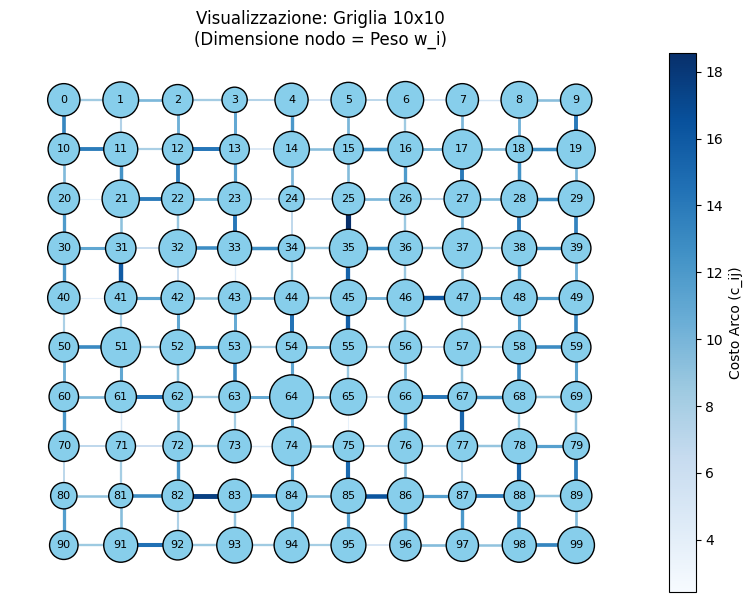

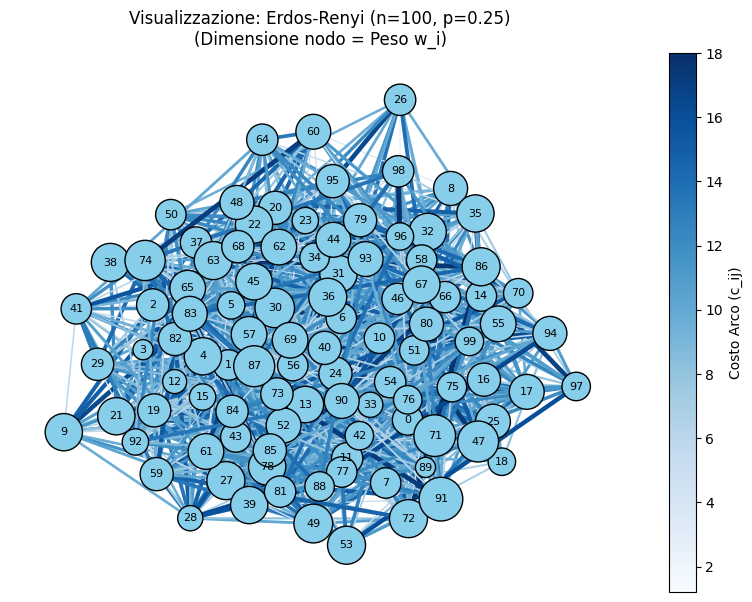

In [8]:
import matplotlib.pyplot as plt

def visualizza_grafo(istanza):
    plt.figure(figsize=(10, 7))
    
    # Ricostruiamo l'oggetto grafo di NetworkX dai dati dell'istanza
    G = nx.Graph()
    G.add_nodes_from(istanza['nodi'])
    G.add_edges_from(istanza['archi'])
    
    # Definiamo il layout (posizionamento dei nodi)
    if "Griglia" in istanza['nome']:
        # Per la griglia usiamo un layout posizionato correttamente
        lato = int(np.sqrt(len(istanza['nodi'])))
        pos = {i: (i % lato, -(i // lato)) for i in istanza['nodi']}
    else:
        # Per Erdos-Renyi usiamo un layout a molla (spring)
        pos = nx.spring_layout(G, seed=42)

    # Parametri grafici basati sui dati Gaussiani
    node_sizes = [istanza['pesi_nodi'][n] * 30 for n in G.nodes()]
    edge_weights = [istanza['costi_archi'][e] for e in G.edges()]
    
    # Disegno
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
    
    # Gli archi hanno spessore proporzionale al costo
    edges = nx.draw_networkx_edges(
        G, pos, 
        width=[w/5 for w in edge_weights], 
        edge_color=edge_weights, 
        edge_cmap=plt.cm.Blues
    )

    plt.colorbar(edges, label='Costo Arco (c_ij)')
    plt.title(f"Visualizzazione: {istanza['nome']}\n(Dimensione nodo = Peso w_i)")
    plt.axis('off')
    plt.show()

# Esegui la visualizzazione
visualizza_grafo(istanza_grid)
visualizza_grafo(istanza_er)

In [9]:
import pulp

def solve_weighted_k_clustering(nodes, edges, node_weights, edge_costs, k, Q, time_limit=60):
    """
    Risolve il problema Weighted K-Clustering.
    
    Args:
        nodes: Lista di ID nodi.
        edges: Lista di tuple (u, v).
        node_weights: Dizionario {id_nodo: peso}.
        edge_costs: Dizionario {(u, v): costo}.
        k: Numero di cluster.
        Q: Capacità massima per cluster.
        time_limit: Tempo massimo in secondi per il solver.
        
    Returns:
        status: Stato della soluzione (Ottimo/Ammissibile).
        clusters: Dizionario {cluster_id: [nodi]}.
        cut_cost: Costo totale del taglio (valore obiettivo).
    """
    
    # 1. Creazione del Problema
    # Usiamo MINIMIZE perché vogliamo minimizzare il costo del taglio
    # Ma useremo la logica: Costo Taglio = Costo Totale Archi - Costo Archi Interni
    prob = pulp.LpProblem("Weighted_K_Clustering", pulp.LpMinimize)
    
    # --- VARIABILI ---
    
    # x[i][h] = 1 se il nodo i è nel cluster h
    x = pulp.LpVariable.dicts("x", 
                              ((i, h) for i in nodes for h in range(k)), 
                              cat='Binary')
    
    # z[u][v][h] = 1 se l'arco (u,v) è INTERAMENTE dentro il cluster h
    # Nota: Creiamo variabili z solo per gli archi esistenti
    z = pulp.LpVariable.dicts("z", 
                              ((u, v, h) for (u, v) in edges for h in range(k)), 
                              cat='Binary')

    # --- FUNZIONE OBIETTIVO ---
    
    # Calcoliamo il costo totale di tutti gli archi nel grafo (costante)
    total_edge_cost = sum(edge_costs[(u,v)] for (u,v) in edges)
    
    # Obiettivo: Minimizzare (Totale - Archi Interni)
    # Ovvero: Minimizzare il costo degli archi che NON sono interni (i.e. quelli tagliati)
    prob += total_edge_cost - pulp.lpSum(edge_costs[(u,v)] * z[(u,v,h)] 
                                         for (u,v) in edges 
                                         for h in range(k))

    # --- VINCOLI ---
    
    # 1. Assegnazione Univoca: Ogni nodo deve stare in un solo cluster
    for i in nodes:
        prob += pulp.lpSum(x[(i, h)] for h in range(k)) == 1, f"Assign_node_{i}"
        
    # 2. Capacità (Knapsack): Il peso totale dei nodi nel cluster h <= Q
    for h in range(k):
        prob += pulp.lpSum(node_weights[i] * x[(i, h)] for i in nodes) <= Q, f"Cap_cluster_{h}"
        
    # 3. Relazione Archi Interni:
    # z[(u,v,h)] può essere 1 SOLO SE sia u che v sono nel cluster h
    # z_uvh <= x_uh  AND  z_uvh <= x_vh
    for (u, v) in edges:
        for h in range(k):
            prob += z[(u,v,h)] <= x[(u,h)], f"Link_Z_X_{u}_{v}_{h}_node_{u}"
            prob += z[(u,v,h)] <= x[(v,h)], f"Link_Z_X_{u}_{v}_{h}_node_{v}"
            # Nota: Non serve forzare z a 1 se x=1, perché la funzione obiettivo 
            # (che "sottrae" z) spingerà z a 1 automaticamente per ridurre il costo.

    # --- RISOLUZIONE ---
    
    # Usiamo il solver CBC (incluso in PuLP)
    solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=time_limit)
    prob.solve(solver)
    
    # --- RECUPERO RISULTATI ---
    
    status = pulp.LpStatus[prob.status]
    print(f"Stato Soluzione: {status}")
    
    final_clusters = {h: [] for h in range(k)}
    
    if status in ["Optimal", "Feasible"]:
        for i in nodes:
            for h in range(k):
                if pulp.value(x[(i, h)]) > 0.9: # Tolleranza float
                    final_clusters[h].append(i)
                    
        obj_val = pulp.value(prob.objective)
        return status, final_clusters, obj_val
    else:
        return status, {}, None

# --- ESEMPIO DI UTILIZZO ---
# (Assumendo di avere i dati generati dallo script precedente)

if __name__ == "__main__":
    # Esempio manuale piccolo per test
    nodes_ex = [0, 1, 2, 3]
    edges_ex = [(0, 1), (1, 2), (2, 3), (0, 3), (0, 2)]
    weights_ex = {0: 10, 1: 10, 2: 10, 3: 10}
    costs_ex = {(0,1): 5, (1,2): 5, (2,3): 5, (0,3): 5, (0,2): 100} # (0,2) costa molto tagliare
    
    k_ex = 2
    Q_ex = 25 # Abbastanza per 2 nodi (20), ma non 3
    
    stat, clus, cut = solve_weighted_k_clustering(nodes_ex, edges_ex, weights_ex, costs_ex, k_ex, Q_ex)
    
    print(f"\nCosto del Taglio Minimo: {cut}")
    for h, nodi in clus.items():
        peso_tot = sum(weights_ex[n] for n in nodi)
        print(f"Cluster {h}: Nodi {nodi} (Peso tot: {peso_tot})")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ernico/tooling/venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/b512916fd5f3433fb899e0ad495855c6-pulp.mps -sec 60 -timeMode elapsed -branch -printingOptions all -solution /tmp/b512916fd5f3433fb899e0ad495855c6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 31 COLUMNS
At line 134 RHS
At line 161 BOUNDS
At line 180 ENDATA
Problem MODEL has 26 rows, 18 columns and 56 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 60
Option for timeMode changed from cpu to elapsed
Continuous objective value is -120 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 22 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 18 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 sub


Istanza Generata: Griglia 4x4
Vincoli: K=3, Q_limit=130.0, W_tot=260
 -> Avvio Solver per K=3, Q=130.0 (TimeLimit=30s)...
Stato Finale: Optimal
Costo del Multi-Cut: 43.27
  - Cluster 0: 6 nodi (Peso: 90/130.0) -> [0, 1, 4, 5, 8, 9]
  - Cluster 1: 2 nodi (Peso: 45/130.0) -> [12, 13]
  - Cluster 2: 8 nodi (Peso: 125/130.0) -> [2, 3, 6, 7, 10, 11, 14, 15]


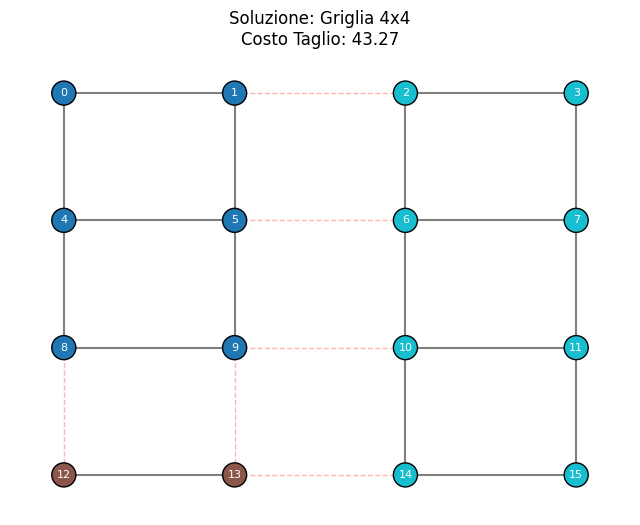


Istanza Generata: Erdos-Renyi (n=15, p=0.25)
Vincoli: K=3, Q_limit=160.5, W_tot=321
 -> Avvio Solver per K=3, Q=160.5 (TimeLimit=30s)...
Stato Finale: Optimal
Costo del Multi-Cut: 90.37
  - Cluster 0: 6 nodi (Peso: 119/160.5) -> [2, 3, 6, 7, 9, 10]
  - Cluster 1: 7 nodi (Peso: 157/160.5) -> [0, 1, 4, 8, 11, 13, 14]
  - Cluster 2: 2 nodi (Peso: 45/160.5) -> [5, 12]


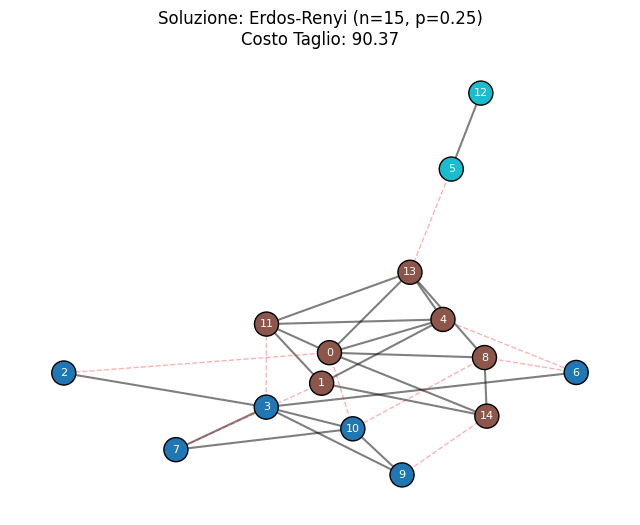

In [10]:
import networkx as nx
import numpy as np
import pulp
import matplotlib.pyplot as plt

# ==========================================
# 1. GENERAZIONE DATI (Data Gen)
# ==========================================
def genera_istanza(tipo_grafo, n_nodi, k_cluster, params_dist):
    """
    Genera un'istanza del problema Weighted K-Clustering.
    """
    # 1. Topologia
    if tipo_grafo == "grid":
        lato = int(np.sqrt(n_nodi))
        G = nx.grid_2d_graph(lato, lato)
        G = nx.convert_node_labels_to_integers(G)
        nome = f"Griglia {lato}x{lato}"
    elif tipo_grafo == "erdos":
        G = nx.erdos_renyi_graph(n=n_nodi, p=0.25, seed=42)
        while not nx.is_connected(G):
             G = nx.erdos_renyi_graph(n=n_nodi, p=0.25)
        nome = f"Erdos-Renyi (n={n_nodi}, p=0.25)"

    # 2. Pesi Nodi (w)
    weights = {}
    tot_W = 0
    for i in G.nodes():
        w = int(np.random.normal(params_dist['w_mu'], params_dist['w_sigma']))
        w = max(1, w) 
        weights[i] = w
        tot_W += w
        
    # 3. Costi Archi (c)
    costs = {}
    for (u, v) in G.edges():
        c = np.random.normal(params_dist['c_mu'], params_dist['c_sigma'])
        c = round(max(0.1, c), 2)
        costs[(u, v)] = c

    # 4. Calcolo Q (Capacità)
    Q = (3 * tot_W) / (2 * k_cluster)
    
    return {
        "nome": nome,
        "nodi": list(G.nodes()),
        "archi": list(G.edges()),
        "pesi_nodi": weights,
        "costi_archi": costs,
        "W_totale": tot_W,
        "K": k_cluster,
        "Q_limit": round(Q, 2)
    }

# ==========================================
# 2. SOLVER (Ottimizzazione)
# ==========================================
def solve_weighted_k_clustering(nodes, edges, node_weights, edge_costs, k, Q, time_limit=30):
    print(f" -> Avvio Solver per K={k}, Q={Q:.1f} (TimeLimit={time_limit}s)...")
    
    # Inizializzazione Problema
    prob = pulp.LpProblem("Weighted_K_Clustering", pulp.LpMinimize)
    
    # Variabili
    x = pulp.LpVariable.dicts("x", ((i, h) for i in nodes for h in range(k)), cat='Binary')
    z = pulp.LpVariable.dicts("z", ((u, v, h) for (u, v) in edges for h in range(k)), cat='Binary')

    # Funzione Obiettivo: Minimizzare (Costo Totale - Costo Archi Interni)
    total_edge_cost = sum(edge_costs[(u,v)] for (u,v) in edges)
    prob += total_edge_cost - pulp.lpSum(edge_costs[(u,v)] * z[(u,v,h)] 
                                         for (u,v) in edges for h in range(k))

    # Vincoli
    # 1. Ogni nodo in un solo cluster
    for i in nodes:
        prob += pulp.lpSum(x[(i, h)] for h in range(k)) == 1
        
    # 2. Capacità Cluster
    for h in range(k):
        prob += pulp.lpSum(node_weights[i] * x[(i, h)] for i in nodes) <= Q
        
    # 3. Legame Archi Interni
    for (u, v) in edges:
        for h in range(k):
            prob += z[(u,v,h)] <= x[(u,h)]
            prob += z[(u,v,h)] <= x[(v,h)]

    # Risoluzione (silenziosa per pulizia output)
    solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=time_limit)
    prob.solve(solver)
    
    # Parsing Risultati
    status = pulp.LpStatus[prob.status]
    final_clusters = {h: [] for h in range(k)}
    node_assignment = {} # Utile per la colorazione
    
    if status in ["Optimal", "Feasible"]:
        for i in nodes:
            for h in range(k):
                if pulp.value(x[(i, h)]) > 0.9:
                    final_clusters[h].append(i)
                    node_assignment[i] = h
        obj_val = pulp.value(prob.objective)
        return status, final_clusters, obj_val, node_assignment
    else:
        return status, {}, None, {}

# ==========================================
# 3. VISUALIZZAZIONE RISULTATI
# ==========================================
def visualizza_soluzione(istanza, node_assignment, costo_taglio):
    plt.figure(figsize=(8, 6))
    G = nx.Graph()
    G.add_nodes_from(istanza['nodi'])
    G.add_edges_from(istanza['archi'])
    
    # Layout
    if "Griglia" in istanza['nome']:
        lato = int(np.sqrt(len(istanza['nodi'])))
        pos = {i: (i % lato, -(i // lato)) for i in istanza['nodi']}
    else:
        pos = nx.spring_layout(G, seed=42)

    # Colori dei nodi in base al cluster (usiamo una colormap tab10)
    colors = [node_assignment.get(n, 0) for n in G.nodes()]
    
    # Disegno
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=colors, cmap=plt.cm.tab10, edgecolors='k')
    nx.draw_networkx_labels(G, pos, font_color='white', font_size=8)
    
    # Evidenziamo gli archi tagliati (quelli tra nodi di colore diverso)
    edges_internal = []
    edges_cut = []
    for u, v in G.edges():
        if node_assignment.get(u) == node_assignment.get(v):
            edges_internal.append((u, v))
        else:
            edges_cut.append((u, v))
            
    nx.draw_networkx_edges(G, pos, edgelist=edges_internal, width=1.5, alpha=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=edges_cut, width=1.0, alpha=0.3, style='dashed', edge_color='red')

    plt.title(f"Soluzione: {istanza['nome']}\nCosto Taglio: {costo_taglio:.2f}")
    plt.axis('off')
    plt.show()

# ==========================================
# 4. MAIN INTEGRATO
# ==========================================
if __name__ == "__main__":
    # Parametri per le distribuzioni Gaussiane
    params = {'w_mu': 20, 'w_sigma': 5, 'c_mu': 10, 'c_sigma': 3}
    
    # Definizione delle due istanze
    istanze_da_risolvere = [
        ("grid", 16, 3),   # Griglia 4x4, 3 Cluster
        ("erdos", 15, 3)   # Erdos-Renyi 15 nodi, 3 Cluster
    ]
    
    for tipo, n, k in istanze_da_risolvere:
        print("\n" + "="*50)
        
        # 1. Generazione
        data = genera_istanza(tipo, n, k, params)
        print(f"Istanza Generata: {data['nome']}")
        print(f"Vincoli: K={data['K']}, Q_limit={data['Q_limit']}, W_tot={data['W_totale']}")
        
        # 2. Risoluzione
        stato, clusters, costo, mapping = solve_weighted_k_clustering(
            nodes=data['nodi'],
            edges=data['archi'],
            node_weights=data['pesi_nodi'],
            edge_costs=data['costi_archi'],
            k=data['K'],
            Q=data['Q_limit']
        )
        
        # 3. Report
        print(f"Stato Finale: {stato}")
        if stato in ["Optimal", "Feasible"]:
            print(f"Costo del Multi-Cut: {costo:.2f}")
            for h, nodi in clusters.items():
                peso_cluster = sum(data['pesi_nodi'][x] for x in nodi)
                print(f"  - Cluster {h}: {len(nodi)} nodi (Peso: {peso_cluster}/{data['Q_limit']}) -> {nodi}")
            
            # 4. Visualizzazione Grafica
            visualizza_soluzione(data, mapping, costo)
        else:
            print("Nessuna soluzione trovata nei limiti di tempo/vincoli.")

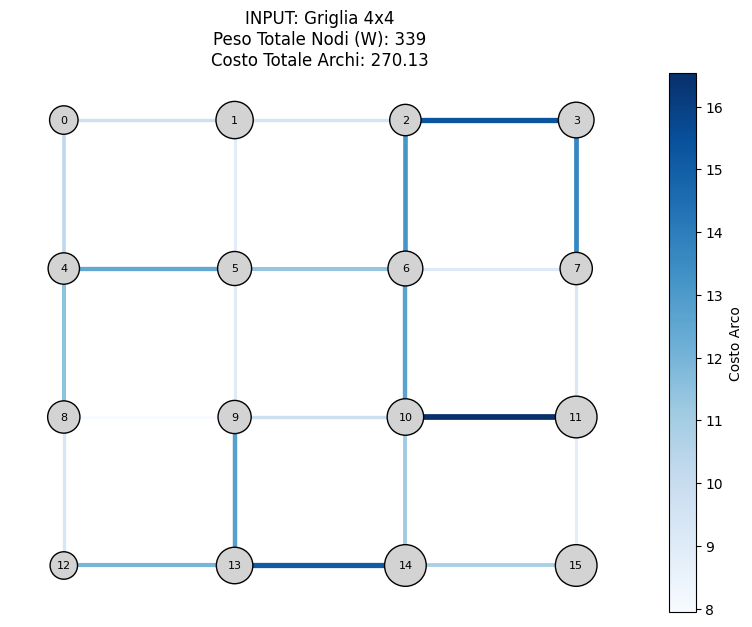

 -> Avvio Solver per Griglia 4x4...


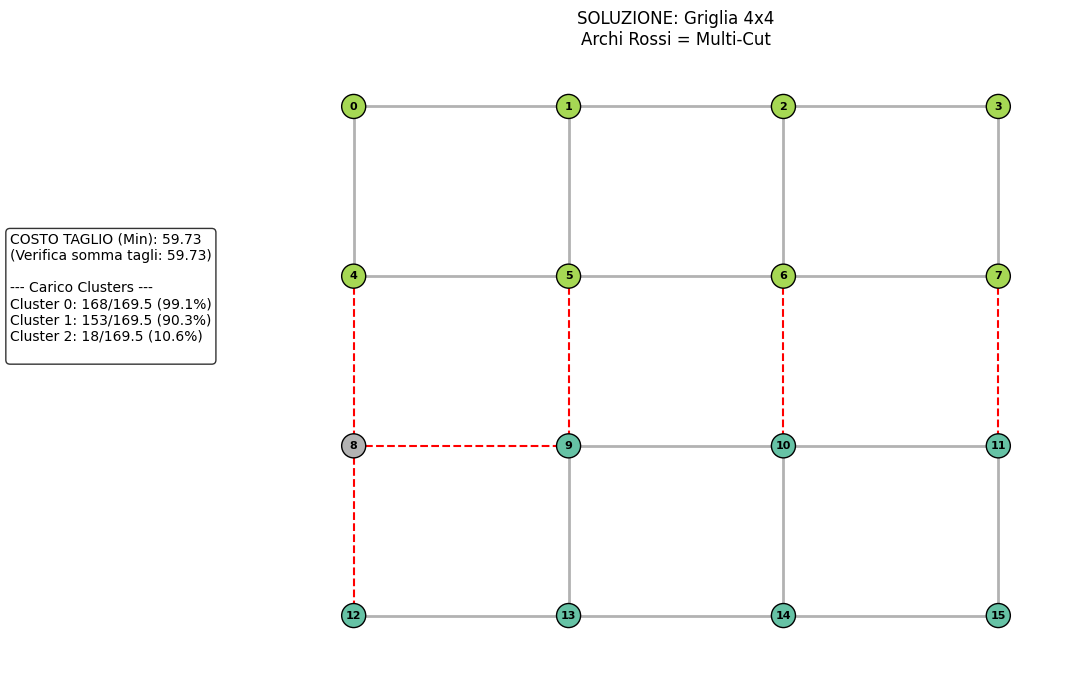

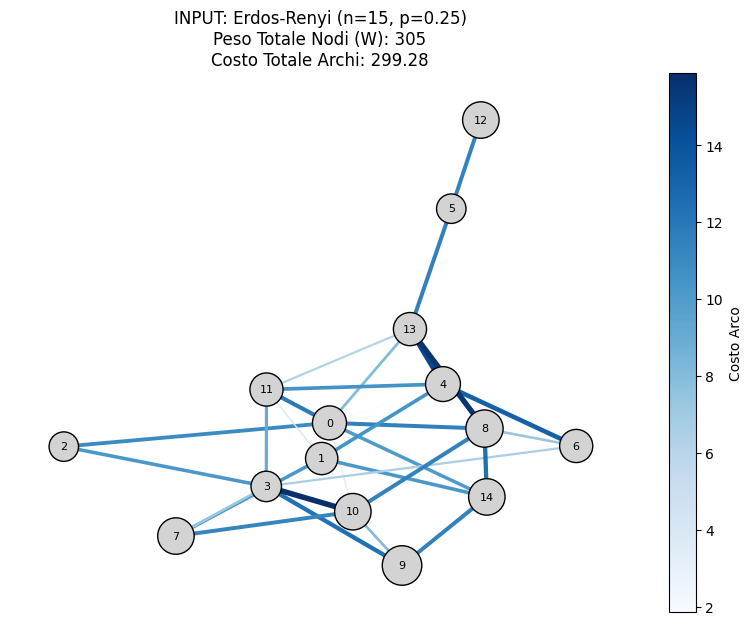

 -> Avvio Solver per Erdos-Renyi (n=15, p=0.25)...


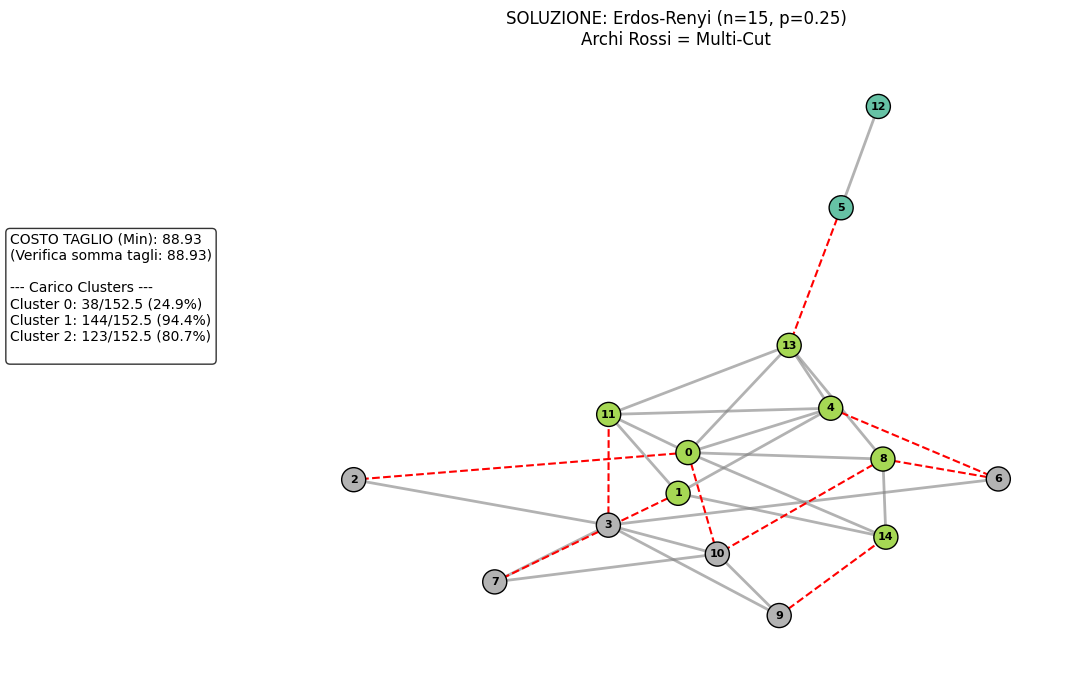

In [11]:
import networkx as nx
import numpy as np
import pulp
import matplotlib.pyplot as plt

# ==========================================
# 1. GENERAZIONE DATI
# ==========================================
def genera_istanza(tipo_grafo, n_nodi, k_cluster, params_dist):
    # 1. Topologia
    if tipo_grafo == "grid":
        lato = int(np.sqrt(n_nodi))
        G = nx.grid_2d_graph(lato, lato)
        G = nx.convert_node_labels_to_integers(G)
        nome = f"Griglia {lato}x{lato}"
    elif tipo_grafo == "erdos":
        G = nx.erdos_renyi_graph(n=n_nodi, p=0.25, seed=42)
        while not nx.is_connected(G):
             G = nx.erdos_renyi_graph(n=n_nodi, p=0.25)
        nome = f"Erdos-Renyi (n={n_nodi}, p=0.25)"

    # 2. Pesi Nodi (w) e Costi Archi (c)
    weights = {}
    tot_W = 0
    for i in G.nodes():
        w = int(np.random.normal(params_dist['w_mu'], params_dist['w_sigma']))
        w = max(1, w) 
        weights[i] = w
        tot_W += w
        
    costs = {}
    tot_C = 0
    for (u, v) in G.edges():
        c = np.random.normal(params_dist['c_mu'], params_dist['c_sigma'])
        c = round(max(0.1, c), 2)
        costs[(u, v)] = c
        tot_C += c

    # 3. Calcolo Q
    Q = (3 * tot_W) / (2 * k_cluster)
    
    return {
        "nome": nome,
        "nodi": list(G.nodes()),
        "archi": list(G.edges()),
        "pesi_nodi": weights,
        "costi_archi": costs,
        "W_totale": tot_W,
        "C_totale": round(tot_C, 2),
        "K": k_cluster,
        "Q_limit": round(Q, 2)
    }

# ==========================================
# 2. SOLVER
# ==========================================
def solve_weighted_k_clustering(data, time_limit=30):
    nodes = data['nodi']
    edges = data['archi']
    k = data['K']
    Q = data['Q_limit']
    
    print(f" -> Avvio Solver per {data['nome']}...")
    
    prob = pulp.LpProblem("Weighted_K_Clustering", pulp.LpMinimize)
    
    x = pulp.LpVariable.dicts("x", ((i, h) for i in nodes for h in range(k)), cat='Binary')
    z = pulp.LpVariable.dicts("z", ((u, v, h) for (u, v) in edges for h in range(k)), cat='Binary')

    total_edge_cost = sum(data['costi_archi'][(u,v)] for (u,v) in edges)
    prob += total_edge_cost - pulp.lpSum(data['costi_archi'][(u,v)] * z[(u,v,h)] 
                                         for (u,v) in edges for h in range(k))

    for i in nodes:
        prob += pulp.lpSum(x[(i, h)] for h in range(k)) == 1
        
    for h in range(k):
        prob += pulp.lpSum(data['pesi_nodi'][i] * x[(i, h)] for i in nodes) <= Q
        
    for (u, v) in edges:
        for h in range(k):
            prob += z[(u,v,h)] <= x[(u,h)]
            prob += z[(u,v,h)] <= x[(v,h)]

    solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=time_limit)
    prob.solve(solver)
    
    status = pulp.LpStatus[prob.status]
    final_clusters = {h: [] for h in range(k)}
    node_assignment = {}
    
    if status in ["Optimal", "Feasible"]:
        for i in nodes:
            for h in range(k):
                if pulp.value(x[(i, h)]) > 0.9:
                    final_clusters[h].append(i)
                    node_assignment[i] = h
        obj_val = pulp.value(prob.objective)
        return status, final_clusters, obj_val, node_assignment
    else:
        return status, {}, None, {}

# ==========================================
# 3. VISUALIZZAZIONE AVANZATA
# ==========================================

def get_layout(istanza, G):
    """Restituisce un layout coerente per entrambe le visualizzazioni"""
    if "Griglia" in istanza['nome']:
        lato = int(np.sqrt(len(istanza['nodi'])))
        return {i: (i % lato, -(i // lato)) for i in istanza['nodi']}
    else:
        return nx.spring_layout(G, seed=42) # Seed fisso per layout identico pre/post

def visualizza_pre_soluzione(istanza):
    plt.figure(figsize=(10, 7))
    G = nx.Graph()
    G.add_nodes_from(istanza['nodi'])
    G.add_edges_from(istanza['archi'])
    pos = get_layout(istanza, G)
    
    # Dati grafici
    node_sizes = [istanza['pesi_nodi'][n] * 30 for n in G.nodes()]
    edge_weights = [istanza['costi_archi'][e] for e in G.edges()]
    
    # Disegno
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightgray', edgecolors='k')
    nx.draw_networkx_labels(G, pos, font_size=8)
    edges = nx.draw_networkx_edges(G, pos, width=[w/4 for w in edge_weights], 
                                   edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    
    # Colorbar e Info
    plt.colorbar(edges, label='Costo Arco')
    stats = (f"Peso Totale Nodi (W): {istanza['W_totale']}\n"
             f"Costo Totale Archi: {istanza['C_totale']}")
    
    plt.title(f"INPUT: {istanza['nome']}\n{stats}")
    plt.axis('off')
    plt.show()

def visualizza_post_soluzione(istanza, node_assignment, costo_taglio, clusters):
    plt.figure(figsize=(12, 8)) # Un po' più larga per la legenda
    G = nx.Graph()
    G.add_nodes_from(istanza['nodi'])
    G.add_edges_from(istanza['archi'])
    pos = get_layout(istanza, G) # Stesso layout del Pre!
    
    # 1. Colori Nodi
    colors = [node_assignment.get(n, 0) for n in G.nodes()]
    
    # 2. Archi Tagliati vs Interni
    edges_internal = []
    edges_cut = []
    peso_tagliato = 0
    
    for u, v in G.edges():
        if node_assignment.get(u) == node_assignment.get(v):
            edges_internal.append((u, v))
        else:
            edges_cut.append((u, v))
            peso_tagliato += istanza['costi_archi'][(u,v)]

    # Disegno
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=colors, cmap=plt.cm.Set2, edgecolors='k')
    nx.draw_networkx_labels(G, pos, font_color='black', font_size=8, font_weight='bold')
    
    # Archi interni (solidi)
    nx.draw_networkx_edges(G, pos, edgelist=edges_internal, width=2.0, alpha=0.6, edge_color='gray')
    # Archi tagliati (tratteggiati rossi)
    nx.draw_networkx_edges(G, pos, edgelist=edges_cut, width=1.5, alpha=1.0, 
                           style='dashed', edge_color='red')

    # Creazione Statistiche per il titolo/legenda
    cluster_stats = ""
    for h, nodi in clusters.items():
        peso_c = sum(istanza['pesi_nodi'][n] for n in nodi)
        perc = (peso_c / istanza['Q_limit']) * 100
        cluster_stats += f"Cluster {h}: {peso_c}/{istanza['Q_limit']} ({perc:.1f}%)\n"
    
    info_box = (f"COSTO TAGLIO (Min): {costo_taglio:.2f}\n"
                f"(Verifica somma tagli: {peso_tagliato:.2f})\n\n"
                f"--- Carico Clusters ---\n{cluster_stats}")
    
    # Aggiungiamo un box di testo laterale
    plt.gcf().text(0.02, 0.5, info_box, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
    plt.title(f"SOLUZIONE: {istanza['nome']}\nArchi Rossi = Multi-Cut")
    # Spostiamo il grafo leggermente a destra per far spazio al testo
    plt.subplots_adjust(left=0.25) 
    plt.axis('off')
    plt.show()

# ==========================================
# 4. MAIN
# ==========================================
if __name__ == "__main__":
    params = {'w_mu': 20, 'w_sigma': 5, 'c_mu': 10, 'c_sigma': 3}
    
    # Lista istanze (Tipo, Nodi, K)
    scenarios = [("grid", 16, 3), ("erdos", 15, 3)]
    
    for tipo, n, k in scenarios:
        # 1. Genera
        data = genera_istanza(tipo, n, k, params)
        
        # 2. Visualizza INPUT
        visualizza_pre_soluzione(data)
        
        # 3. Risolvi
        stato, clusters, costo, mapping = solve_weighted_k_clustering(data)
        
        # 4. Visualizza OUTPUT se risolto
        if stato in ["Optimal", "Feasible"]:
            visualizza_post_soluzione(data, mapping, costo, clusters)
        else:
            print(f"Impossibile trovare soluzione per {data['nome']}")

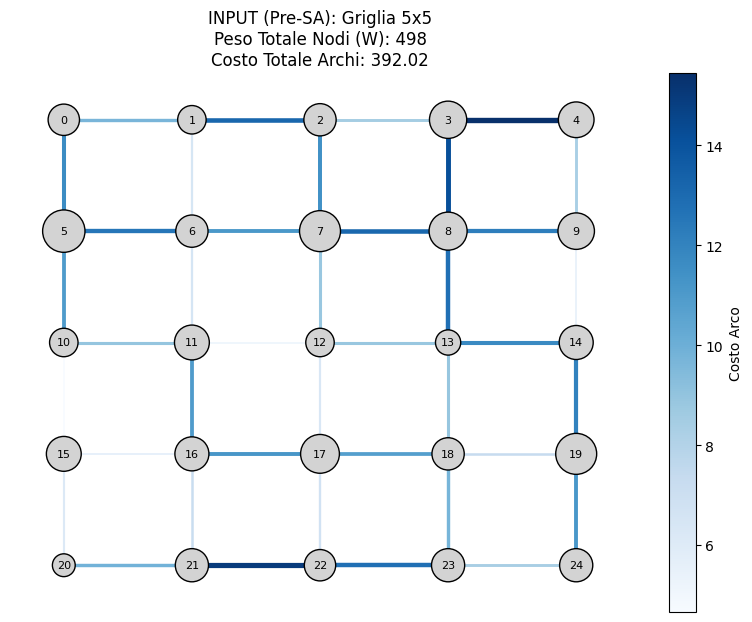

 -> Avvio Simulated Annealing per Griglia 5x5...
    Terminato. Best Cost: 76.82


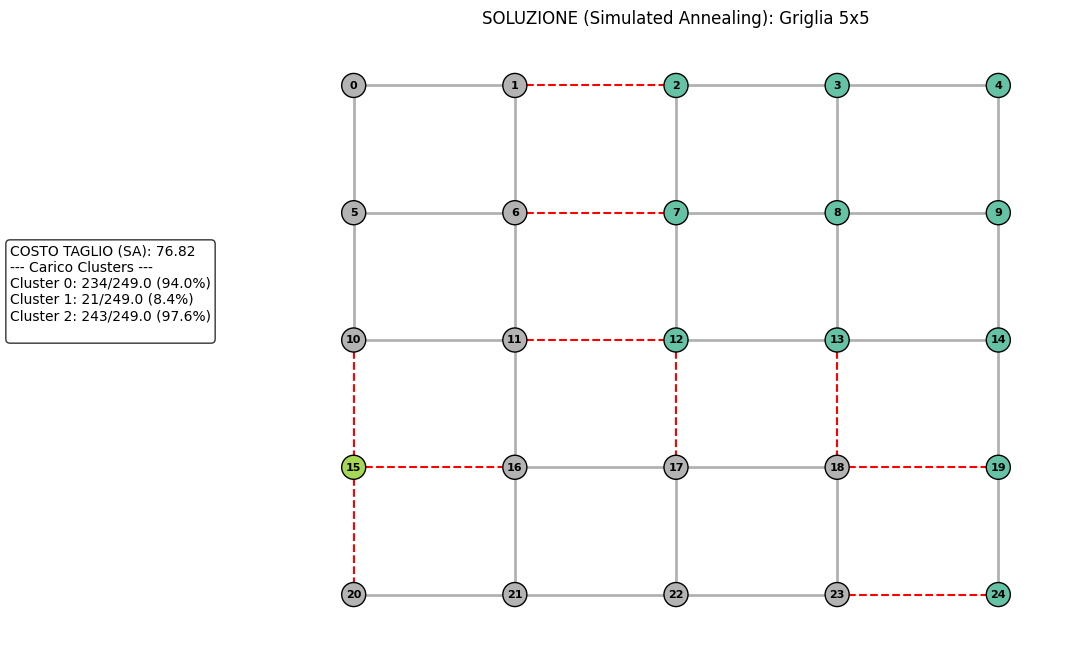

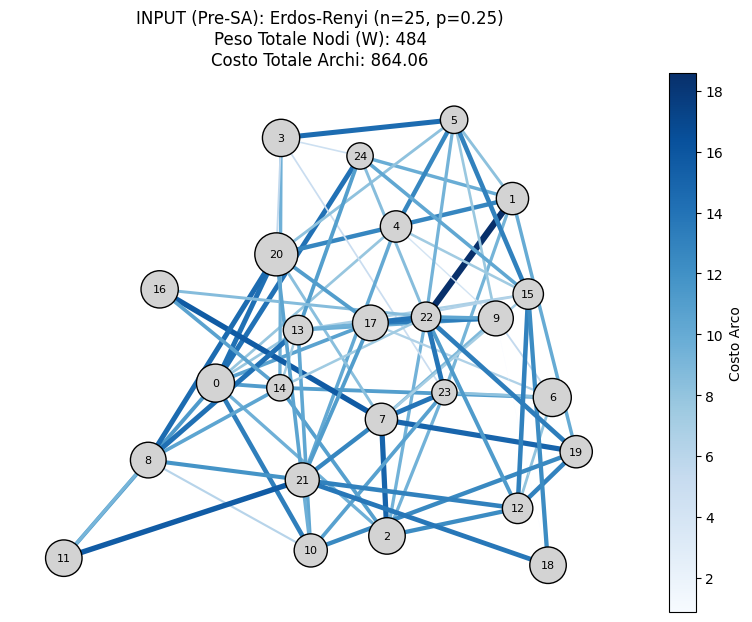

 -> Avvio Simulated Annealing per Erdos-Renyi (n=25, p=0.25)...
    Terminato. Best Cost: 363.64


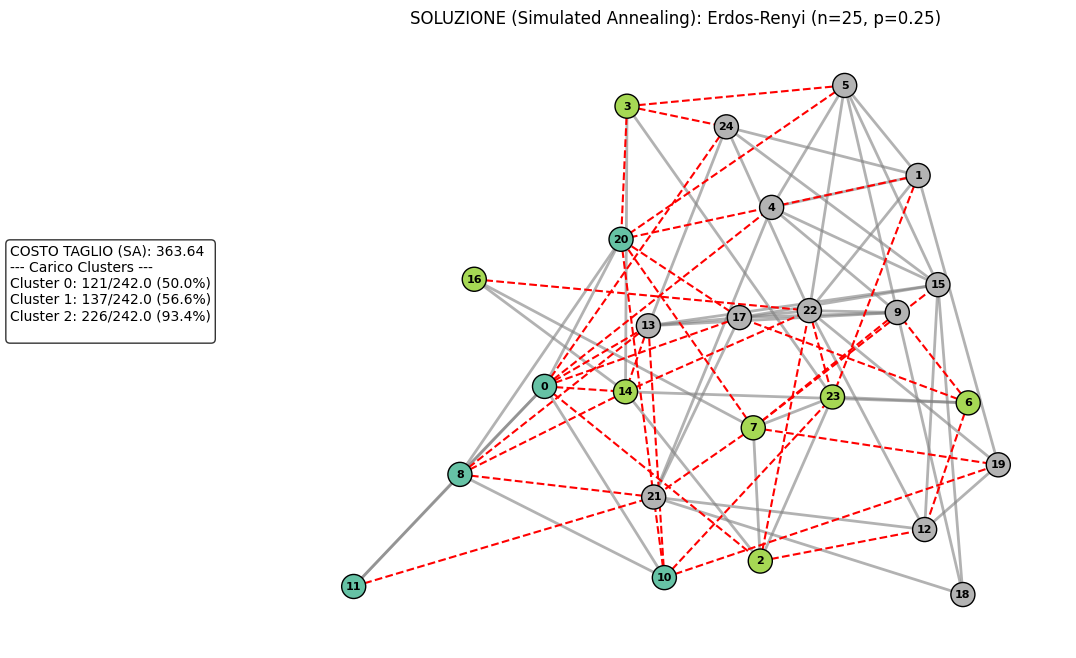

In [12]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import copy

# ==========================================
# 1. GENERAZIONE DATI (Identica a prima)
# ==========================================
def genera_istanza(tipo_grafo, n_nodi, k_cluster, params_dist):
    # Topologia
    if tipo_grafo == "grid":
        lato = int(np.sqrt(n_nodi))
        G = nx.grid_2d_graph(lato, lato)
        G = nx.convert_node_labels_to_integers(G)
        nome = f"Griglia {lato}x{lato}"
    elif tipo_grafo == "erdos":
        G = nx.erdos_renyi_graph(n=n_nodi, p=0.25, seed=42)
        while not nx.is_connected(G):
             G = nx.erdos_renyi_graph(n=n_nodi, p=0.25)
        nome = f"Erdos-Renyi (n={n_nodi}, p=0.25)"

    # Pesi e Costi
    weights = {}
    tot_W = 0
    for i in G.nodes():
        w = int(np.random.normal(params_dist['w_mu'], params_dist['w_sigma']))
        w = max(1, w) 
        weights[i] = w
        tot_W += w
        
    costs = {}
    tot_C = 0
    for (u, v) in G.edges():
        c = np.random.normal(params_dist['c_mu'], params_dist['c_sigma'])
        c = round(max(0.1, c), 2)
        costs[(u, v)] = c
        tot_C += c

    Q = (3 * tot_W) / (2 * k_cluster)
    
    return {
        "nome": nome,
        "nodi": list(G.nodes()),
        "archi": list(G.edges()),
        "pesi_nodi": weights,
        "costi_archi": costs,
        "W_totale": tot_W,
        "C_totale": round(tot_C, 2),
        "K": k_cluster,
        "Q_limit": round(Q, 2)
    }

# ==========================================
# 2. SIMULATED ANNEALING ENGINE
# ==========================================

def calcola_costo_taglio(assignment, edges, costs):
    """Calcola il costo totale degli archi tagliati per una data assegnazione."""
    cut_cost = 0
    for u, v in edges:
        if assignment[u] != assignment[v]:
            cut_cost += costs[(u, v)]
    return cut_cost

def genera_soluzione_iniziale(nodes, weights, k, Q):
    """Genera una soluzione random valida (rispetta Q)."""
    assignment = {}
    cluster_weights = {h: 0 for h in range(k)}
    
    # Tentiamo di riempire i cluster in modo casuale
    # Nota: su istanze molto strette questo approccio greedy-random potrebbe fallire,
    # ma con Q = 1.5 * W/k c'è molto spazio di manovra.
    nodi_da_assegnare = list(nodes)
    random.shuffle(nodi_da_assegnare)
    
    for n in nodi_da_assegnare:
        assigned = False
        possible_clusters = list(range(k))
        random.shuffle(possible_clusters)
        
        for h in possible_clusters:
            if cluster_weights[h] + weights[n] <= Q:
                assignment[n] = h
                cluster_weights[h] += weights[n]
                assigned = True
                break
        
        if not assigned:
            # Fallback (non dovrebbe accadere spesso con Q largo): 
            # forza l'assegnazione al cluster meno carico
            h_min = min(cluster_weights, key=cluster_weights.get)
            assignment[n] = h_min
            cluster_weights[h_min] += weights[n]
            
    return assignment

def simulated_annealing_solver(data, temp_iniziale=1000, alpha=0.95, max_iter=2000):
    print(f" -> Avvio Simulated Annealing per {data['nome']}...")
    
    nodes = data['nodi']
    edges = data['archi']
    weights = data['pesi_nodi']
    costs = data['costi_archi']
    k = data['K']
    Q = data['Q_limit']

    # 1. Soluzione Iniziale
    current_assignment = genera_soluzione_iniziale(nodes, weights, k, Q)
    current_cost = calcola_costo_taglio(current_assignment, edges, costs)
    
    # Teniamo traccia del "Best So Far"
    best_assignment = current_assignment.copy()
    best_cost = current_cost
    
    T = temp_iniziale
    
    # Loop SA
    for i in range(max_iter):
        # 2. Mossa: Seleziona nodo random e cluster target random
        nodo = random.choice(nodes)
        old_cluster = current_assignment[nodo]
        new_cluster = random.choice([h for h in range(k) if h != old_cluster])
        
        # 3. Verifica Ammissibilità (Vincolo Q)
        # Calcoliamo il peso attuale del nuovo cluster
        peso_target = sum(weights[n] for n, c in current_assignment.items() if c == new_cluster)
        
        if peso_target + weights[nodo] <= Q:
            # Mossa ammissibile: Calcoliamo Delta E (variazione costo)
            # Ottimizzazione: invece di ricalcolare tutto, calcoliamo solo sui vicini
            # Ma per semplicità e chiarezza didattica, ricalcoliamo tutto (su grafi piccoli è ok)
            
            # Creiamo assegnazione temporanea
            new_assignment = current_assignment.copy()
            new_assignment[nodo] = new_cluster
            new_cost = calcola_costo_taglio(new_assignment, edges, costs)
            
            delta = new_cost - current_cost
            
            # 4. Metropolis Criterion
            accetta = False
            if delta < 0:
                accetta = True # Miglioramento
            else:
                p = math.exp(-delta / T)
                if random.random() < p:
                    accetta = True # Accettazione peggioramento (esplorazione)
            
            if accetta:
                current_assignment = new_assignment
                current_cost = new_cost
                
                # Aggiornamento Best Global
                if current_cost < best_cost:
                    best_cost = current_cost
                    best_assignment = current_assignment.copy()
        
        # 5. Raffreddamento
        T = T * alpha
        # Opzionale: Restart se T diventa troppo basso
        if T < 0.01: T = 0.01

    # Formattazione Output compatibile con le funzioni di visualizzazione
    final_clusters = {h: [] for h in range(k)}
    for n, h in best_assignment.items():
        final_clusters[h].append(n)
        
    print(f"    Terminato. Best Cost: {best_cost:.2f}")
    return "Feasible", final_clusters, best_cost, best_assignment

# ==========================================
# 3. VISUALIZZAZIONE (Identica a prima)
# ==========================================
def get_layout(istanza, G):
    if "Griglia" in istanza['nome']:
        lato = int(np.sqrt(len(istanza['nodi'])))
        return {i: (i % lato, -(i // lato)) for i in istanza['nodi']}
    else:
        return nx.spring_layout(G, seed=42)

def visualizza_pre_soluzione(istanza):
    plt.figure(figsize=(10, 7))
    G = nx.Graph()
    G.add_nodes_from(istanza['nodi'])
    G.add_edges_from(istanza['archi'])
    pos = get_layout(istanza, G)
    
    node_sizes = [istanza['pesi_nodi'][n] * 30 for n in G.nodes()]
    edge_weights = [istanza['costi_archi'][e] for e in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightgray', edgecolors='k')
    nx.draw_networkx_labels(G, pos, font_size=8)
    edges = nx.draw_networkx_edges(G, pos, width=[w/4 for w in edge_weights], 
                                   edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    plt.colorbar(edges, label='Costo Arco')
    
    stats = (f"Peso Totale Nodi (W): {istanza['W_totale']}\n"
             f"Costo Totale Archi: {istanza['C_totale']}")
    plt.title(f"INPUT (Pre-SA): {istanza['nome']}\n{stats}")
    plt.axis('off')
    plt.show()

def visualizza_post_soluzione(istanza, node_assignment, costo_taglio, clusters):
    plt.figure(figsize=(12, 8))
    G = nx.Graph()
    G.add_nodes_from(istanza['nodi'])
    G.add_edges_from(istanza['archi'])
    pos = get_layout(istanza, G)
    
    colors = [node_assignment.get(n, 0) for n in G.nodes()]
    
    edges_internal = []
    edges_cut = []
    peso_tagliato = 0
    for u, v in G.edges():
        if node_assignment.get(u) == node_assignment.get(v):
            edges_internal.append((u, v))
        else:
            edges_cut.append((u, v))
            peso_tagliato += istanza['costi_archi'][(u,v)]

    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=colors, cmap=plt.cm.Set2, edgecolors='k')
    nx.draw_networkx_labels(G, pos, font_color='black', font_size=8, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edgelist=edges_internal, width=2.0, alpha=0.6, edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=edges_cut, width=1.5, alpha=1.0, style='dashed', edge_color='red')

    cluster_stats = ""
    for h in sorted(clusters.keys()):
        nodi = clusters[h]
        peso_c = sum(istanza['pesi_nodi'][n] for n in nodi)
        perc = (peso_c / istanza['Q_limit']) * 100
        cluster_stats += f"Cluster {h}: {peso_c}/{istanza['Q_limit']} ({perc:.1f}%)\n"
    
    info_box = (f"COSTO TAGLIO (SA): {costo_taglio:.2f}\n"
                f"--- Carico Clusters ---\n{cluster_stats}")
    
    plt.gcf().text(0.02, 0.5, info_box, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
    plt.title(f"SOLUZIONE (Simulated Annealing): {istanza['nome']}")
    plt.subplots_adjust(left=0.25) 
    plt.axis('off')
    plt.show()

# ==========================================
# 4. MAIN
# ==========================================
if __name__ == "__main__":
    params = {'w_mu': 20, 'w_sigma': 5, 'c_mu': 10, 'c_sigma': 3}
    
    # Aumentiamo un po' i nodi per rendere il SA più interessante
    # 25 nodi (griglia 5x5) e 25 nodi random
    scenarios = [("grid", 25, 3), ("erdos", 25, 3)]
    
    for tipo, n, k in scenarios:
        # 1. Genera
        data = genera_istanza(tipo, n, k, params)
        
        # 2. Visualizza INPUT
        visualizza_pre_soluzione(data)
        
        # 3. Risolvi con SA (Parametri modificabili per tuning)
        stato, clusters, costo, mapping = simulated_annealing_solver(
            data, 
            temp_iniziale=500, 
            alpha=0.98,      # Raffreddamento lento
            max_iter=5000    # Molte iterazioni
        )
        
        # 4. Visualizza OUTPUT
        visualizza_post_soluzione(data, mapping, costo, clusters)

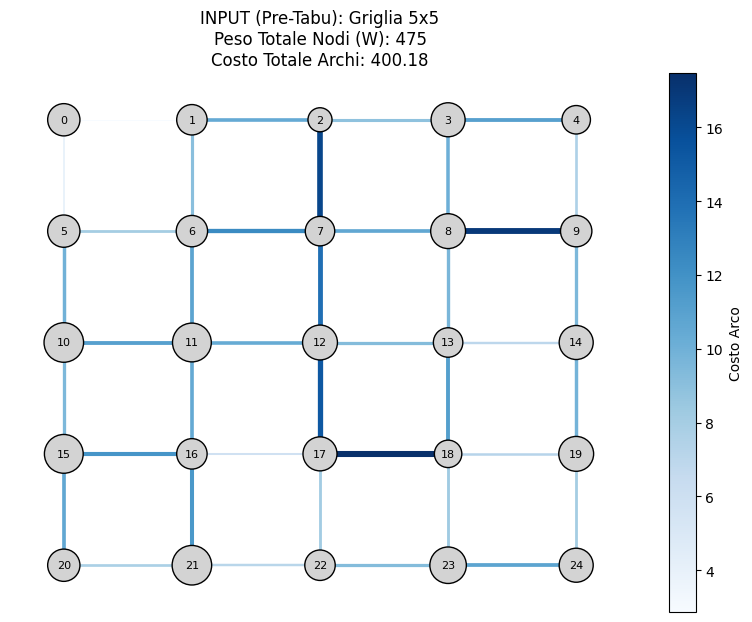

 -> Avvio Tabu Search per Griglia 5x5...
    Iter 0: Nuovo record trovato -> 202.61
    Iter 1: Nuovo record trovato -> 190.30
    Iter 2: Nuovo record trovato -> 153.28
    Iter 3: Nuovo record trovato -> 138.11
    Iter 4: Nuovo record trovato -> 127.31
    Iter 5: Nuovo record trovato -> 121.69
    Iter 6: Nuovo record trovato -> 114.49
    Iter 7: Nuovo record trovato -> 111.12
    Iter 8: Nuovo record trovato -> 110.02
    Iter 9: Nuovo record trovato -> 109.67
    Iter 11: Nuovo record trovato -> 102.65
    Iter 14: Nuovo record trovato -> 101.48
    Iter 16: Nuovo record trovato -> 96.47
    Iter 17: Nuovo record trovato -> 86.13
    Iter 18: Nuovo record trovato -> 79.95
    Iter 19: Nuovo record trovato -> 76.89
    Iter 21: Nuovo record trovato -> 76.07
    Iter 24: Nuovo record trovato -> 74.36
    Iter 110: Nuovo record trovato -> 74.04
    Iter 143: Nuovo record trovato -> 71.69
    Iter 144: Nuovo record trovato -> 70.59
    Iter 340: Nuovo record trovato -> 69.29


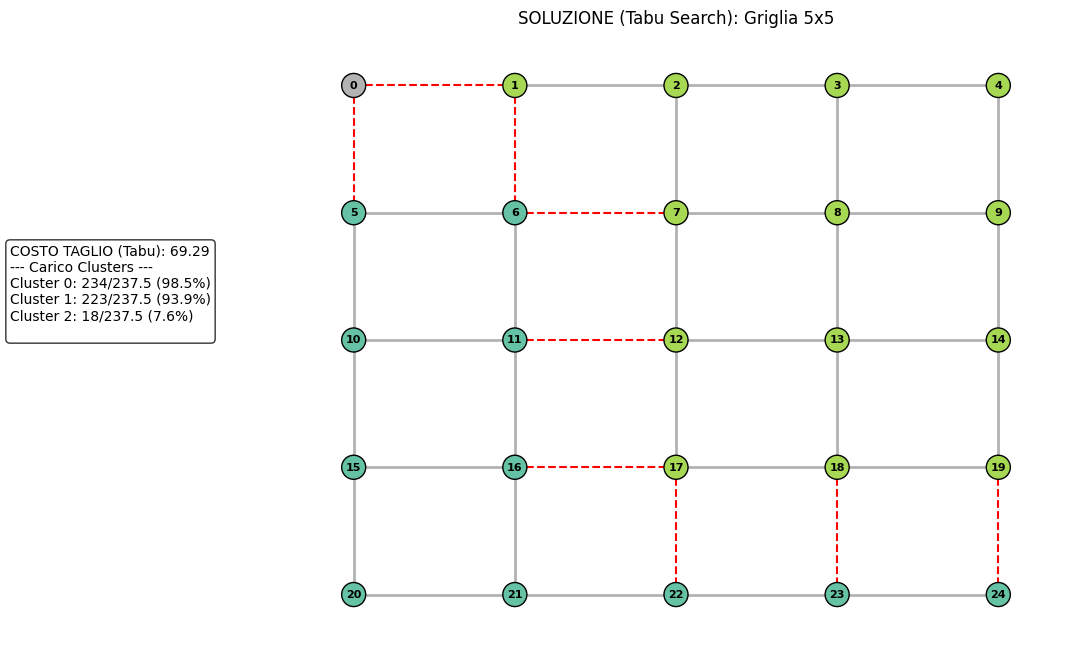

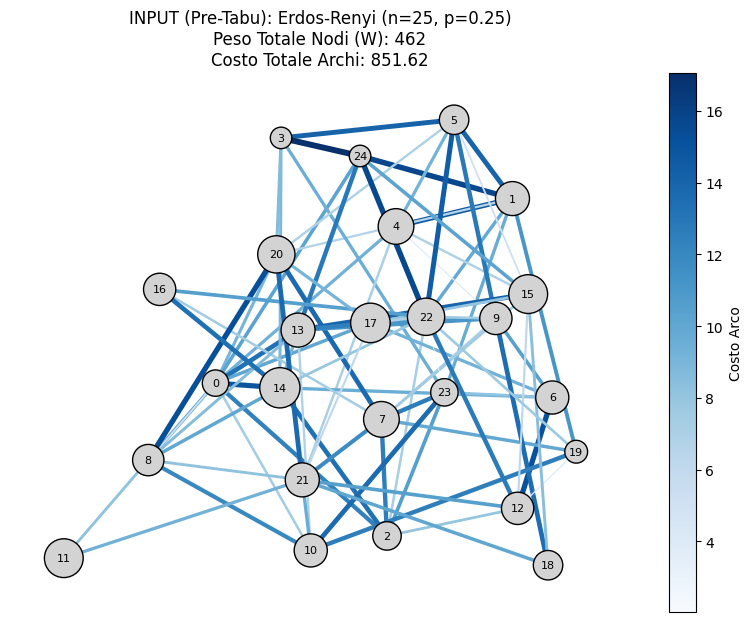

 -> Avvio Tabu Search per Erdos-Renyi (n=25, p=0.25)...
    Iter 0: Nuovo record trovato -> 524.98
    Iter 1: Nuovo record trovato -> 498.40
    Iter 2: Nuovo record trovato -> 476.07
    Iter 3: Nuovo record trovato -> 454.79
    Iter 4: Nuovo record trovato -> 434.68
    Iter 5: Nuovo record trovato -> 425.04
    Iter 6: Nuovo record trovato -> 417.65
    Iter 10: Nuovo record trovato -> 389.01
    Iter 11: Nuovo record trovato -> 380.26
    Iter 12: Nuovo record trovato -> 365.77
    Iter 13: Nuovo record trovato -> 342.17
    Iter 14: Nuovo record trovato -> 324.66
    Iter 21: Nuovo record trovato -> 310.29
    Iter 22: Nuovo record trovato -> 306.48
    Iter 26: Nuovo record trovato -> 303.89
    Iter 29: Nuovo record trovato -> 284.17
    Iter 211: Nuovo record trovato -> 283.49
    Iter 249: Nuovo record trovato -> 280.19
    Iter 261: Nuovo record trovato -> 277.61
    Iter 262: Nuovo record trovato -> 273.44
    Iter 292: Nuovo record trovato -> 270.79


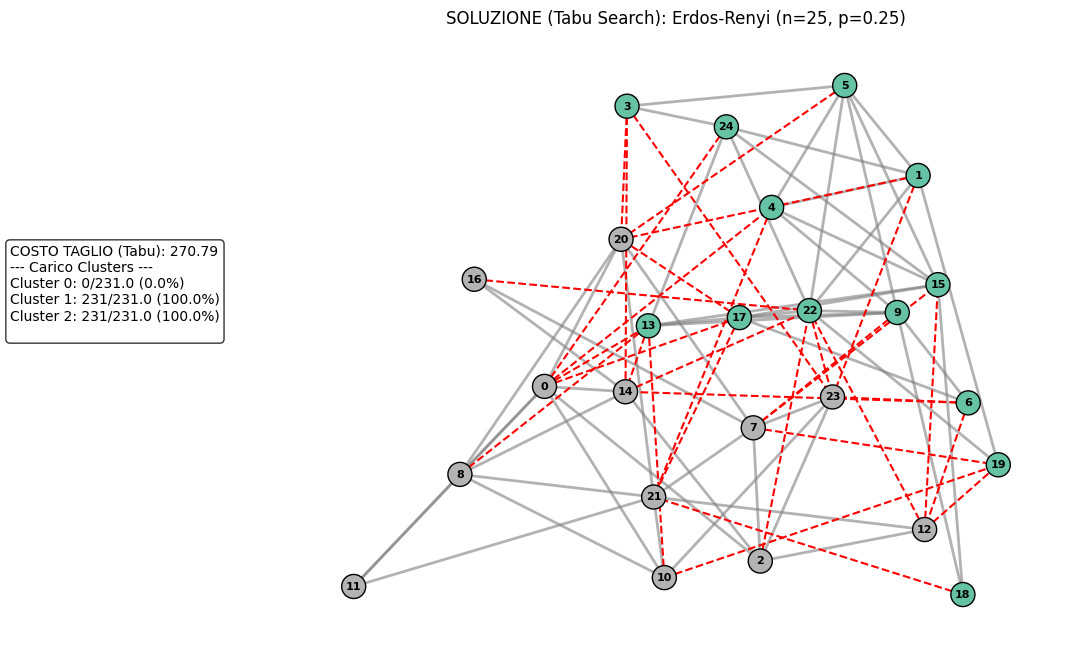

In [14]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

# ==========================================
# 1. GENERAZIONE DATI (Standard)
# ==========================================
def genera_istanza(tipo_grafo, n_nodi, k_cluster, params_dist):
    if tipo_grafo == "grid":
        lato = int(np.sqrt(n_nodi))
        G = nx.grid_2d_graph(lato, lato)
        G = nx.convert_node_labels_to_integers(G)
        nome = f"Griglia {lato}x{lato}"
    elif tipo_grafo == "erdos":
        G = nx.erdos_renyi_graph(n=n_nodi, p=0.25, seed=42)
        while not nx.is_connected(G):
             G = nx.erdos_renyi_graph(n=n_nodi, p=0.25)
        nome = f"Erdos-Renyi (n={n_nodi}, p=0.25)"

    weights = {}
    tot_W = 0
    for i in G.nodes():
        w = int(np.random.normal(params_dist['w_mu'], params_dist['w_sigma']))
        w = max(1, w) 
        weights[i] = w
        tot_W += w
        
    costs = {}
    tot_C = 0
    for (u, v) in G.edges():
        c = np.random.normal(params_dist['c_mu'], params_dist['c_sigma'])
        c = round(max(0.1, c), 2)
        costs[(u, v)] = c
        tot_C += c

    Q = (3 * tot_W) / (2 * k_cluster)
    
    return {
        "nome": nome,
        "nodi": list(G.nodes()),
        "archi": list(G.edges()),
        "pesi_nodi": weights,
        "costi_archi": costs,
        "W_totale": tot_W,
        "C_totale": round(tot_C, 2),
        "K": k_cluster,
        "Q_limit": round(Q, 2)
    }

# ==========================================
# 2. TABU SEARCH ENGINE
# ==========================================

def calcola_costo_taglio(assignment, edges, costs):
    cut_cost = 0
    for u, v in edges:
        if assignment[u] != assignment[v]:
            cut_cost += costs[(u, v)]
    return cut_cost

def genera_soluzione_iniziale(nodes, weights, k, Q):
    """Genera una soluzione random ammissibile."""
    assignment = {}
    cluster_weights = {h: 0 for h in range(k)}
    nodi_da_assegnare = list(nodes)
    random.shuffle(nodi_da_assegnare)
    
    for n in nodi_da_assegnare:
        assigned = False
        candidates = list(range(k))
        random.shuffle(candidates)
        for h in candidates:
            if cluster_weights[h] + weights[n] <= Q:
                assignment[n] = h
                cluster_weights[h] += weights[n]
                assigned = True
                break
        if not assigned:
            # Fallback greedy
            h_min = min(cluster_weights, key=cluster_weights.get)
            assignment[n] = h_min
            cluster_weights[h_min] += weights[n]
    return assignment

def tabu_search_solver(data, max_iter=200, tabu_tenure=5, sample_size=30):
    print(f" -> Avvio Tabu Search per {data['nome']}...")
    
    nodes = data['nodi']
    edges = data['archi']
    weights = data['pesi_nodi']
    costs = data['costi_archi']
    k = data['K']
    Q = data['Q_limit']

    # 1. Inizializzazione
    current_assignment = genera_soluzione_iniziale(nodes, weights, k, Q)
    current_cost = calcola_costo_taglio(current_assignment, edges, costs)
    
    best_assignment = current_assignment.copy()
    best_cost = current_cost
    
    # Tabu List: dizionario {nodo: iterazione_in_cui_scade_il_divieto}
    tabu_list = {} 

    # Loop Principale
    for iteration in range(max_iter):
        
        # 2. Generazione Vicinato (Candidate Moves)
        # Una mossa è: (nodo, nuovo_cluster)
        candidates = []
        
        # Campioniamo dei nodi a caso per non esplorare tutto lo spazio (che sarebbe lento su N grandi)
        nodi_sample = random.sample(nodes, min(len(nodes), sample_size))
        
        for nodo in nodi_sample:
            old_cluster = current_assignment[nodo]
            # Possibili cluster di destinazione
            possibili_destinazioni = [h for h in range(k) if h != old_cluster]
            
            for dest in possibili_destinazioni:
                # Controlliamo ammissibilità (Capacità Q)
                # Calcolo peso attuale destinazione
                peso_dest = sum(weights[n] for n, c in current_assignment.items() if c == dest)
                
                if peso_dest + weights[nodo] <= Q:
                    # Mossa ammissibile. Valutiamo il costo ipotetico.
                    # Per velocità, cloniamo solo per il calcolo
                    temp_assignment = current_assignment.copy()
                    temp_assignment[nodo] = dest
                    costo_cand = calcola_costo_taglio(temp_assignment, edges, costs)
                    candidates.append((nodo, dest, costo_cand))

        # 3. Selezione Migliore Mossa (non Tabu o Aspirata)
        best_candidate_move = None
        
        # Ordiniamo i candidati per costo crescente (migliore prima)
        candidates.sort(key=lambda x: x[2])
        
        found_move = False
        for node, dest, cost in candidates:
            is_tabu = (node in tabu_list and tabu_list[node] > iteration)
            is_better_than_global_best = (cost < best_cost)
            
            # Criterio di Aspirazione: se è Tabu ma è Best Global, la prendiamo!
            if (not is_tabu) or is_better_than_global_best:
                best_candidate_move = (node, dest, cost)
                found_move = True
                break # Trovata la migliore ammissibile secondo logica TS
        
        if found_move:
            node_move, dest_move, new_cost = best_candidate_move
            
            # Eseguiamo la mossa
            current_assignment[node_move] = dest_move
            current_cost = new_cost
            
            # Aggiorniamo Tabu List
            # Il nodo mosso diventa tabu per 'tabu_tenure' iterazioni
            tabu_list[node_move] = iteration + tabu_tenure
            
            # Aggiorniamo Best Global
            if current_cost < best_cost:
                best_cost = current_cost
                best_assignment = current_assignment.copy()
                print(f"    Iter {iteration}: Nuovo record trovato -> {best_cost:.2f}")
        else:
            # Nessuna mossa valida trovata (tutte violano Q o sono bloccate)
            pass

    # Formattazione Output
    final_clusters = {h: [] for h in range(k)}
    for n, h in best_assignment.items():
        final_clusters[h].append(n)
        
    return "Feasible", final_clusters, best_cost, best_assignment

# ==========================================
# 3. VISUALIZZAZIONE (Standard)
# ==========================================
def get_layout(istanza, G):
    if "Griglia" in istanza['nome']:
        lato = int(np.sqrt(len(istanza['nodi'])))
        return {i: (i % lato, -(i // lato)) for i in istanza['nodi']}
    else:
        return nx.spring_layout(G, seed=42)

def visualizza_pre_soluzione(istanza):
    plt.figure(figsize=(10, 7))
    G = nx.Graph()
    G.add_nodes_from(istanza['nodi'])
    G.add_edges_from(istanza['archi'])
    pos = get_layout(istanza, G)
    
    node_sizes = [istanza['pesi_nodi'][n] * 30 for n in G.nodes()]
    edge_weights = [istanza['costi_archi'][e] for e in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightgray', edgecolors='k')
    nx.draw_networkx_labels(G, pos, font_size=8)
    edges = nx.draw_networkx_edges(G, pos, width=[w/4 for w in edge_weights], 
                                   edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    plt.colorbar(edges, label='Costo Arco')
    
    stats = (f"Peso Totale Nodi (W): {istanza['W_totale']}\n"
             f"Costo Totale Archi: {istanza['C_totale']}")
    plt.title(f"INPUT (Pre-Tabu): {istanza['nome']}\n{stats}")
    plt.axis('off')
    plt.show()

def visualizza_post_soluzione(istanza, node_assignment, costo_taglio, clusters):
    plt.figure(figsize=(12, 8))
    G = nx.Graph()
    G.add_nodes_from(istanza['nodi'])
    G.add_edges_from(istanza['archi'])
    pos = get_layout(istanza, G)
    
    colors = [node_assignment.get(n, 0) for n in G.nodes()]
    
    edges_internal = []
    edges_cut = []
    peso_tagliato = 0
    for u, v in G.edges():
        if node_assignment.get(u) == node_assignment.get(v):
            edges_internal.append((u, v))
        else:
            edges_cut.append((u, v))
            peso_tagliato += istanza['costi_archi'][(u,v)]

    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=colors, cmap=plt.cm.Set2, edgecolors='k')
    nx.draw_networkx_labels(G, pos, font_color='black', font_size=8, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edgelist=edges_internal, width=2.0, alpha=0.6, edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=edges_cut, width=1.5, alpha=1.0, style='dashed', edge_color='red')

    cluster_stats = ""
    for h in sorted(clusters.keys()):
        nodi = clusters[h]
        peso_c = sum(istanza['pesi_nodi'][n] for n in nodi)
        perc = (peso_c / istanza['Q_limit']) * 100
        cluster_stats += f"Cluster {h}: {peso_c}/{istanza['Q_limit']} ({perc:.1f}%)\n"
    
    info_box = (f"COSTO TAGLIO (Tabu): {costo_taglio:.2f}\n"
                f"--- Carico Clusters ---\n{cluster_stats}")
    
    plt.gcf().text(0.02, 0.5, info_box, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
    plt.title(f"SOLUZIONE (Tabu Search): {istanza['nome']}")
    plt.subplots_adjust(left=0.25) 
    plt.axis('off')
    plt.show()

# ==========================================
# 4. MAIN
# ==========================================
if __name__ == "__main__":
    params = {'w_mu': 20, 'w_sigma': 5, 'c_mu': 10, 'c_sigma': 3}
    
    # 25 nodi (griglia 5x5) e 25 nodi random
    scenarios = [("grid", 25, 3), ("erdos", 25, 3)]
    
    for tipo, n, k in scenarios:
        # 1. Genera
        data = genera_istanza(tipo, n, k, params)
        
        # 2. Visualizza INPUT
        visualizza_pre_soluzione(data)
        
        # 3. Risolvi con Tabu Search
        stato, clusters, costo, mapping = tabu_search_solver(
            data, 
            max_iter=1000,      # Iterazioni
            tabu_tenure=7,     # Per quanti turni un nodo resta bloccato
            sample_size=30     # Quanti vicini valutare a ogni step
        )
        
        # 4. Visualizza OUTPUT
        visualizza_post_soluzione(data, mapping, costo, clusters)